# Getting started with Word2Vec in Gensim and making it work!

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [2]:
# imports needed and set up logging
import gzip
import gensim 
import logging
import glob, os
import math
import numpy as np

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [167]:
import os,sys
sys.path.insert(0,"/home/msykulski/workspace/genXone/hackyeah2019/jupyter_init_workspace/src/")

import multiprocmap
from multiprocmap import parmap

In [170]:
data_file2="/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/0**/*"

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [202]:
%%time 

#filenames=[]

def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    files=[file for file in glob.glob(input_file)]
    def line_generator(file):
        with open(file, 'rb') as f:
            #filenames.append(file)
            for i, line in enumerate (f): 
            #if (i%10000==0):
                #logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
                yield gensim.utils.simple_preprocess (line)
            yield ["GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF"]
    all_lines=lambda file:(file,[l for l in line_generator(file)])
    #all_f_l=parmap(all_lines)
    return parmap(all_lines,files)
    

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
#documents2 = list (read_input(data_file2))
all_f_l = read_input(data_file2)

documents2_org = [f_l[1] for f_l in all_f_l]
filenames_org = [f_l[0] for f_l in all_f_l]

logging.info ("Done reading data file")    

2019-09-15 04:06:14,687 : INFO : reading file /mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/0**/*...this may take a while
2019-09-15 04:06:53,510 : INFO : Done reading data file


CPU times: user 22.2 s, sys: 15.1 s, total: 37.3 s
Wall time: 38.8 s


In [185]:
len(filenames_org)
documents2=[g for l in documents2_org for g in l]

## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [189]:
%%time
model = gensim.models.Word2Vec (documents2, size=150, window=10, min_count=1, workers=88)
model.train(documents2,total_examples=len(documents2),epochs=10)

2019-09-15 03:27:04,895 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-09-15 03:27:04,896 : INFO : collecting all words and their counts
2019-09-15 03:27:04,896 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-15 03:27:04,911 : INFO : PROGRESS: at sentence #10000, processed 57459 words, keeping 33912 word types
2019-09-15 03:27:04,921 : INFO : PROGRESS: at sentence #20000, processed 94743 words, keeping 43652 word types
2019-09-15 03:27:04,932 : INFO : PROGRESS: at sentence #30000, processed 127729 words, keeping 48819 word types
2019-09-15 03:27:04,941 : INFO : PROGRESS: at sentence #40000, processed 163781 words, keeping 53992 word types
2019-09-15 03:27:04,953 : INFO : PROGRESS: at sentence #50000, processed 205417 words, keeping 65051 word types
2019-09-15 03:27:04,963 : INFO : PROGRESS: at sentence #60000, processed 247372 words, keeping 69060 word types
2019-09-15 03:27:04,974 : INFO : PROGRESS: at sentenc

2019-09-15 03:27:05,596 : INFO : PROGRESS: at sentence #710000, processed 2643479 words, keeping 283254 word types
2019-09-15 03:27:05,605 : INFO : PROGRESS: at sentence #720000, processed 2676713 words, keeping 284898 word types
2019-09-15 03:27:05,615 : INFO : PROGRESS: at sentence #730000, processed 2714195 words, keeping 286573 word types
2019-09-15 03:27:05,625 : INFO : PROGRESS: at sentence #740000, processed 2753904 words, keeping 288423 word types
2019-09-15 03:27:05,635 : INFO : PROGRESS: at sentence #750000, processed 2791244 words, keeping 290015 word types
2019-09-15 03:27:05,646 : INFO : PROGRESS: at sentence #760000, processed 2836841 words, keeping 292244 word types
2019-09-15 03:27:05,656 : INFO : PROGRESS: at sentence #770000, processed 2877146 words, keeping 294080 word types
2019-09-15 03:27:05,666 : INFO : PROGRESS: at sentence #780000, processed 2918421 words, keeping 295842 word types
2019-09-15 03:27:05,675 : INFO : PROGRESS: at sentence #790000, processed 295341

2019-09-15 03:27:06,279 : INFO : PROGRESS: at sentence #1420000, processed 5269450 words, keeping 430835 word types
2019-09-15 03:27:06,288 : INFO : PROGRESS: at sentence #1430000, processed 5305446 words, keeping 432490 word types
2019-09-15 03:27:06,297 : INFO : PROGRESS: at sentence #1440000, processed 5342716 words, keeping 434019 word types
2019-09-15 03:27:06,306 : INFO : PROGRESS: at sentence #1450000, processed 5379440 words, keeping 435408 word types
2019-09-15 03:27:06,316 : INFO : PROGRESS: at sentence #1460000, processed 5418368 words, keeping 437315 word types
2019-09-15 03:27:06,324 : INFO : PROGRESS: at sentence #1470000, processed 5449412 words, keeping 439002 word types
2019-09-15 03:27:06,335 : INFO : PROGRESS: at sentence #1480000, processed 5487466 words, keeping 440801 word types
2019-09-15 03:27:06,344 : INFO : PROGRESS: at sentence #1490000, processed 5527730 words, keeping 442228 word types
2019-09-15 03:27:06,357 : INFO : PROGRESS: at sentence #1500000, process

2019-09-15 03:27:06,950 : INFO : PROGRESS: at sentence #2130000, processed 7895099 words, keeping 586300 word types
2019-09-15 03:27:06,958 : INFO : PROGRESS: at sentence #2140000, processed 7928695 words, keeping 587222 word types
2019-09-15 03:27:06,967 : INFO : PROGRESS: at sentence #2150000, processed 7959901 words, keeping 588326 word types
2019-09-15 03:27:06,975 : INFO : PROGRESS: at sentence #2160000, processed 7994959 words, keeping 589605 word types
2019-09-15 03:27:06,985 : INFO : PROGRESS: at sentence #2170000, processed 8032024 words, keeping 590982 word types
2019-09-15 03:27:06,994 : INFO : PROGRESS: at sentence #2180000, processed 8065029 words, keeping 594713 word types
2019-09-15 03:27:07,003 : INFO : PROGRESS: at sentence #2190000, processed 8093633 words, keeping 600915 word types
2019-09-15 03:27:07,013 : INFO : PROGRESS: at sentence #2200000, processed 8133198 words, keeping 602117 word types
2019-09-15 03:27:07,022 : INFO : PROGRESS: at sentence #2210000, process

2019-09-15 03:27:07,636 : INFO : PROGRESS: at sentence #2840000, processed 10511418 words, keeping 700166 word types
2019-09-15 03:27:07,645 : INFO : PROGRESS: at sentence #2850000, processed 10546901 words, keeping 701998 word types
2019-09-15 03:27:07,654 : INFO : PROGRESS: at sentence #2860000, processed 10584933 words, keeping 703639 word types
2019-09-15 03:27:07,664 : INFO : PROGRESS: at sentence #2870000, processed 10619923 words, keeping 707176 word types
2019-09-15 03:27:07,672 : INFO : PROGRESS: at sentence #2880000, processed 10651364 words, keeping 708254 word types
2019-09-15 03:27:07,680 : INFO : PROGRESS: at sentence #2890000, processed 10675069 words, keeping 713509 word types
2019-09-15 03:27:07,689 : INFO : PROGRESS: at sentence #2900000, processed 10711991 words, keeping 714761 word types
2019-09-15 03:27:07,698 : INFO : PROGRESS: at sentence #2910000, processed 10749612 words, keeping 715892 word types
2019-09-15 03:27:07,706 : INFO : PROGRESS: at sentence #2920000,

2019-09-15 03:27:08,306 : INFO : PROGRESS: at sentence #3550000, processed 13135220 words, keeping 830098 word types
2019-09-15 03:27:08,316 : INFO : PROGRESS: at sentence #3560000, processed 13176889 words, keeping 831638 word types
2019-09-15 03:27:08,325 : INFO : PROGRESS: at sentence #3570000, processed 13210682 words, keeping 833048 word types
2019-09-15 03:27:08,335 : INFO : PROGRESS: at sentence #3580000, processed 13246581 words, keeping 834661 word types
2019-09-15 03:27:08,344 : INFO : PROGRESS: at sentence #3590000, processed 13287198 words, keeping 835700 word types
2019-09-15 03:27:08,354 : INFO : PROGRESS: at sentence #3600000, processed 13324403 words, keeping 836950 word types
2019-09-15 03:27:08,366 : INFO : PROGRESS: at sentence #3610000, processed 13362787 words, keeping 838044 word types
2019-09-15 03:27:08,374 : INFO : PROGRESS: at sentence #3620000, processed 13392986 words, keeping 838998 word types
2019-09-15 03:27:08,382 : INFO : PROGRESS: at sentence #3630000,

2019-09-15 03:27:09,025 : INFO : PROGRESS: at sentence #4260000, processed 15753217 words, keeping 948712 word types
2019-09-15 03:27:09,036 : INFO : PROGRESS: at sentence #4270000, processed 15795894 words, keeping 950209 word types
2019-09-15 03:27:09,046 : INFO : PROGRESS: at sentence #4280000, processed 15827095 words, keeping 951724 word types
2019-09-15 03:27:09,056 : INFO : PROGRESS: at sentence #4290000, processed 15863651 words, keeping 952706 word types
2019-09-15 03:27:09,066 : INFO : PROGRESS: at sentence #4300000, processed 15900215 words, keeping 953935 word types
2019-09-15 03:27:09,077 : INFO : PROGRESS: at sentence #4310000, processed 15939085 words, keeping 954830 word types
2019-09-15 03:27:09,087 : INFO : PROGRESS: at sentence #4320000, processed 15975015 words, keeping 956019 word types
2019-09-15 03:27:09,097 : INFO : PROGRESS: at sentence #4330000, processed 16014143 words, keeping 957159 word types
2019-09-15 03:27:09,109 : INFO : PROGRESS: at sentence #4340000,

2019-09-15 03:27:09,792 : INFO : PROGRESS: at sentence #4960000, processed 18392228 words, keeping 1040987 word types
2019-09-15 03:27:09,803 : INFO : PROGRESS: at sentence #4970000, processed 18428805 words, keeping 1043709 word types
2019-09-15 03:27:09,815 : INFO : PROGRESS: at sentence #4980000, processed 18457861 words, keeping 1047508 word types
2019-09-15 03:27:09,827 : INFO : PROGRESS: at sentence #4990000, processed 18496085 words, keeping 1048563 word types
2019-09-15 03:27:09,838 : INFO : PROGRESS: at sentence #5000000, processed 18533777 words, keeping 1049516 word types
2019-09-15 03:27:09,849 : INFO : PROGRESS: at sentence #5010000, processed 18569720 words, keeping 1050184 word types
2019-09-15 03:27:09,859 : INFO : PROGRESS: at sentence #5020000, processed 18604452 words, keeping 1051267 word types
2019-09-15 03:27:09,872 : INFO : PROGRESS: at sentence #5030000, processed 18645080 words, keeping 1053107 word types
2019-09-15 03:27:09,884 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:10,667 : INFO : PROGRESS: at sentence #5660000, processed 21018666 words, keeping 1174253 word types
2019-09-15 03:27:10,680 : INFO : PROGRESS: at sentence #5670000, processed 21061041 words, keeping 1175592 word types
2019-09-15 03:27:10,689 : INFO : PROGRESS: at sentence #5680000, processed 21094844 words, keeping 1176712 word types
2019-09-15 03:27:10,699 : INFO : PROGRESS: at sentence #5690000, processed 21127490 words, keeping 1177292 word types
2019-09-15 03:27:10,708 : INFO : PROGRESS: at sentence #5700000, processed 21161413 words, keeping 1177956 word types
2019-09-15 03:27:10,720 : INFO : PROGRESS: at sentence #5710000, processed 21204415 words, keeping 1179599 word types
2019-09-15 03:27:10,732 : INFO : PROGRESS: at sentence #5720000, processed 21252703 words, keeping 1180677 word types
2019-09-15 03:27:10,741 : INFO : PROGRESS: at sentence #5730000, processed 21285251 words, keeping 1181752 word types
2019-09-15 03:27:10,751 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:11,383 : INFO : PROGRESS: at sentence #6360000, processed 23578381 words, keeping 1276840 word types
2019-09-15 03:27:11,394 : INFO : PROGRESS: at sentence #6370000, processed 23622951 words, keeping 1277908 word types
2019-09-15 03:27:11,404 : INFO : PROGRESS: at sentence #6380000, processed 23658218 words, keeping 1278768 word types
2019-09-15 03:27:11,414 : INFO : PROGRESS: at sentence #6390000, processed 23694656 words, keeping 1279911 word types
2019-09-15 03:27:11,424 : INFO : PROGRESS: at sentence #6400000, processed 23731223 words, keeping 1280795 word types
2019-09-15 03:27:11,433 : INFO : PROGRESS: at sentence #6410000, processed 23761072 words, keeping 1281632 word types
2019-09-15 03:27:11,442 : INFO : PROGRESS: at sentence #6420000, processed 23797053 words, keeping 1282574 word types
2019-09-15 03:27:11,452 : INFO : PROGRESS: at sentence #6430000, processed 23832320 words, keeping 1283376 word types
2019-09-15 03:27:11,463 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:12,121 : INFO : PROGRESS: at sentence #7060000, processed 26181935 words, keeping 1369973 word types
2019-09-15 03:27:12,132 : INFO : PROGRESS: at sentence #7070000, processed 26221271 words, keeping 1373101 word types
2019-09-15 03:27:12,143 : INFO : PROGRESS: at sentence #7080000, processed 26260483 words, keeping 1374014 word types
2019-09-15 03:27:12,154 : INFO : PROGRESS: at sentence #7090000, processed 26301172 words, keeping 1375058 word types
2019-09-15 03:27:12,166 : INFO : PROGRESS: at sentence #7100000, processed 26346046 words, keeping 1376520 word types
2019-09-15 03:27:12,175 : INFO : PROGRESS: at sentence #7110000, processed 26373983 words, keeping 1379861 word types
2019-09-15 03:27:12,185 : INFO : PROGRESS: at sentence #7120000, processed 26404819 words, keeping 1382997 word types
2019-09-15 03:27:12,199 : INFO : PROGRESS: at sentence #7130000, processed 26444801 words, keeping 1384125 word types
2019-09-15 03:27:12,208 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:12,934 : INFO : PROGRESS: at sentence #7760000, processed 28845490 words, keeping 1450603 word types
2019-09-15 03:27:12,947 : INFO : PROGRESS: at sentence #7770000, processed 28898169 words, keeping 1452248 word types
2019-09-15 03:27:12,958 : INFO : PROGRESS: at sentence #7780000, processed 28935571 words, keeping 1453345 word types
2019-09-15 03:27:12,972 : INFO : PROGRESS: at sentence #7790000, processed 28971850 words, keeping 1454251 word types
2019-09-15 03:27:12,982 : INFO : PROGRESS: at sentence #7800000, processed 29009879 words, keeping 1455050 word types
2019-09-15 03:27:12,992 : INFO : PROGRESS: at sentence #7810000, processed 29044880 words, keeping 1455770 word types
2019-09-15 03:27:13,003 : INFO : PROGRESS: at sentence #7820000, processed 29083279 words, keeping 1456653 word types
2019-09-15 03:27:13,014 : INFO : PROGRESS: at sentence #7830000, processed 29122295 words, keeping 1457452 word types
2019-09-15 03:27:13,023 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:13,708 : INFO : PROGRESS: at sentence #8460000, processed 31415123 words, keeping 1571975 word types
2019-09-15 03:27:13,719 : INFO : PROGRESS: at sentence #8470000, processed 31451165 words, keeping 1572823 word types
2019-09-15 03:27:13,729 : INFO : PROGRESS: at sentence #8480000, processed 31480722 words, keeping 1573960 word types
2019-09-15 03:27:13,744 : INFO : PROGRESS: at sentence #8490000, processed 31520689 words, keeping 1574989 word types
2019-09-15 03:27:13,755 : INFO : PROGRESS: at sentence #8500000, processed 31555947 words, keeping 1575682 word types
2019-09-15 03:27:13,765 : INFO : PROGRESS: at sentence #8510000, processed 31587260 words, keeping 1576633 word types
2019-09-15 03:27:13,777 : INFO : PROGRESS: at sentence #8520000, processed 31627944 words, keeping 1577566 word types
2019-09-15 03:27:13,788 : INFO : PROGRESS: at sentence #8530000, processed 31664107 words, keeping 1579011 word types
2019-09-15 03:27:13,799 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:14,455 : INFO : PROGRESS: at sentence #9160000, processed 33947727 words, keeping 1655924 word types
2019-09-15 03:27:14,466 : INFO : PROGRESS: at sentence #9170000, processed 33984822 words, keeping 1656906 word types
2019-09-15 03:27:14,477 : INFO : PROGRESS: at sentence #9180000, processed 34026004 words, keeping 1658412 word types
2019-09-15 03:27:14,488 : INFO : PROGRESS: at sentence #9190000, processed 34066556 words, keeping 1659524 word types
2019-09-15 03:27:14,501 : INFO : PROGRESS: at sentence #9200000, processed 34102735 words, keeping 1661027 word types
2019-09-15 03:27:14,512 : INFO : PROGRESS: at sentence #9210000, processed 34142191 words, keeping 1662158 word types
2019-09-15 03:27:14,524 : INFO : PROGRESS: at sentence #9220000, processed 34188575 words, keeping 1663274 word types
2019-09-15 03:27:14,537 : INFO : PROGRESS: at sentence #9230000, processed 34229073 words, keeping 1668110 word types
2019-09-15 03:27:14,547 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:15,229 : INFO : PROGRESS: at sentence #9860000, processed 36550705 words, keeping 1742259 word types
2019-09-15 03:27:15,241 : INFO : PROGRESS: at sentence #9870000, processed 36592383 words, keeping 1743382 word types
2019-09-15 03:27:15,253 : INFO : PROGRESS: at sentence #9880000, processed 36632670 words, keeping 1744248 word types
2019-09-15 03:27:15,263 : INFO : PROGRESS: at sentence #9890000, processed 36669424 words, keeping 1745087 word types
2019-09-15 03:27:15,275 : INFO : PROGRESS: at sentence #9900000, processed 36705501 words, keeping 1747700 word types
2019-09-15 03:27:15,291 : INFO : PROGRESS: at sentence #9910000, processed 36763094 words, keeping 1751906 word types
2019-09-15 03:27:15,302 : INFO : PROGRESS: at sentence #9920000, processed 36802941 words, keeping 1752969 word types
2019-09-15 03:27:15,311 : INFO : PROGRESS: at sentence #9930000, processed 36831606 words, keeping 1754006 word types
2019-09-15 03:27:15,321 : INFO : PROGRESS: at sentence #

2019-09-15 03:27:16,031 : INFO : PROGRESS: at sentence #10550000, processed 39108609 words, keeping 1848348 word types
2019-09-15 03:27:16,045 : INFO : PROGRESS: at sentence #10560000, processed 39154248 words, keeping 1852302 word types
2019-09-15 03:27:16,060 : INFO : PROGRESS: at sentence #10570000, processed 39199304 words, keeping 1857928 word types
2019-09-15 03:27:16,072 : INFO : PROGRESS: at sentence #10580000, processed 39240562 words, keeping 1859222 word types
2019-09-15 03:27:16,081 : INFO : PROGRESS: at sentence #10590000, processed 39273768 words, keeping 1859890 word types
2019-09-15 03:27:16,092 : INFO : PROGRESS: at sentence #10600000, processed 39304413 words, keeping 1862087 word types
2019-09-15 03:27:16,103 : INFO : PROGRESS: at sentence #10610000, processed 39342391 words, keeping 1863584 word types
2019-09-15 03:27:16,113 : INFO : PROGRESS: at sentence #10620000, processed 39372650 words, keeping 1864509 word types
2019-09-15 03:27:16,124 : INFO : PROGRESS: at se

2019-09-15 03:27:16,789 : INFO : PROGRESS: at sentence #11240000, processed 41611275 words, keeping 1935955 word types
2019-09-15 03:27:16,800 : INFO : PROGRESS: at sentence #11250000, processed 41651266 words, keeping 1936556 word types
2019-09-15 03:27:16,811 : INFO : PROGRESS: at sentence #11260000, processed 41695953 words, keeping 1937350 word types
2019-09-15 03:27:16,821 : INFO : PROGRESS: at sentence #11270000, processed 41726776 words, keeping 1938016 word types
2019-09-15 03:27:16,831 : INFO : PROGRESS: at sentence #11280000, processed 41759485 words, keeping 1938769 word types
2019-09-15 03:27:16,845 : INFO : PROGRESS: at sentence #11290000, processed 41809800 words, keeping 1940716 word types
2019-09-15 03:27:16,855 : INFO : PROGRESS: at sentence #11300000, processed 41841125 words, keeping 1941644 word types
2019-09-15 03:27:16,866 : INFO : PROGRESS: at sentence #11310000, processed 41877584 words, keeping 1942539 word types
2019-09-15 03:27:16,880 : INFO : PROGRESS: at se

2019-09-15 03:27:17,599 : INFO : PROGRESS: at sentence #11930000, processed 44203690 words, keeping 2043896 word types
2019-09-15 03:27:17,611 : INFO : PROGRESS: at sentence #11940000, processed 44241960 words, keeping 2044631 word types
2019-09-15 03:27:17,623 : INFO : PROGRESS: at sentence #11950000, processed 44279683 words, keeping 2045399 word types
2019-09-15 03:27:17,634 : INFO : PROGRESS: at sentence #11960000, processed 44315330 words, keeping 2046127 word types
2019-09-15 03:27:17,647 : INFO : PROGRESS: at sentence #11970000, processed 44360595 words, keeping 2047018 word types
2019-09-15 03:27:17,659 : INFO : PROGRESS: at sentence #11980000, processed 44399080 words, keeping 2047980 word types
2019-09-15 03:27:17,670 : INFO : PROGRESS: at sentence #11990000, processed 44439261 words, keeping 2048721 word types
2019-09-15 03:27:17,680 : INFO : PROGRESS: at sentence #12000000, processed 44472533 words, keeping 2049370 word types
2019-09-15 03:27:17,690 : INFO : PROGRESS: at se

2019-09-15 03:27:18,443 : INFO : PROGRESS: at sentence #12620000, processed 46702846 words, keeping 2115429 word types
2019-09-15 03:27:18,457 : INFO : PROGRESS: at sentence #12630000, processed 46754267 words, keeping 2116913 word types
2019-09-15 03:27:18,469 : INFO : PROGRESS: at sentence #12640000, processed 46794335 words, keeping 2117723 word types
2019-09-15 03:27:18,480 : INFO : PROGRESS: at sentence #12650000, processed 46831678 words, keeping 2118507 word types
2019-09-15 03:27:18,495 : INFO : PROGRESS: at sentence #12660000, processed 46871544 words, keeping 2122894 word types
2019-09-15 03:27:18,506 : INFO : PROGRESS: at sentence #12670000, processed 46908290 words, keeping 2123625 word types
2019-09-15 03:27:18,516 : INFO : PROGRESS: at sentence #12680000, processed 46942439 words, keeping 2124459 word types
2019-09-15 03:27:18,527 : INFO : PROGRESS: at sentence #12690000, processed 46980727 words, keeping 2125252 word types
2019-09-15 03:27:18,540 : INFO : PROGRESS: at se

2019-09-15 03:28:31,867 : INFO : worker thread finished; awaiting finish of 63 more threads
2019-09-15 03:28:31,873 : INFO : worker thread finished; awaiting finish of 62 more threads
2019-09-15 03:28:31,889 : INFO : worker thread finished; awaiting finish of 61 more threads
2019-09-15 03:28:31,896 : INFO : worker thread finished; awaiting finish of 60 more threads
2019-09-15 03:28:31,897 : INFO : worker thread finished; awaiting finish of 59 more threads
2019-09-15 03:28:31,898 : INFO : worker thread finished; awaiting finish of 58 more threads
2019-09-15 03:28:31,908 : INFO : worker thread finished; awaiting finish of 57 more threads
2019-09-15 03:28:31,909 : INFO : worker thread finished; awaiting finish of 56 more threads
2019-09-15 03:28:31,912 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 03:28:31,916 : INFO : worker thread finished; awaiting finish of 54 more threads
2019-09-15 03:28:31,924 : INFO : worker thread finished; awaiting finish of 53 m

2019-09-15 03:28:52,239 : INFO : EPOCH 2 - PROGRESS: at 57.37% examples, 1250680 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:28:53,244 : INFO : EPOCH 2 - PROGRESS: at 60.24% examples, 1251396 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:28:54,257 : INFO : EPOCH 2 - PROGRESS: at 63.07% examples, 1251588 words/s, in_qsize 174, out_qsize 3
2019-09-15 03:28:55,276 : INFO : EPOCH 2 - PROGRESS: at 66.06% examples, 1252568 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:28:56,295 : INFO : EPOCH 2 - PROGRESS: at 69.01% examples, 1251840 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:28:57,315 : INFO : EPOCH 2 - PROGRESS: at 72.19% examples, 1255367 words/s, in_qsize 173, out_qsize 2
2019-09-15 03:28:58,319 : INFO : EPOCH 2 - PROGRESS: at 75.15% examples, 1256809 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:28:59,342 : INFO : EPOCH 2 - PROGRESS: at 78.08% examples, 1257640 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:29:00,350 : INFO : EPOCH 2 - PROGRESS: at 81.07% examples,

2019-09-15 03:29:06,137 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-09-15 03:29:06,138 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-09-15 03:29:06,138 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-09-15 03:29:06,138 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-09-15 03:29:06,138 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-09-15 03:29:06,139 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-09-15 03:29:06,139 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-09-15 03:29:06,139 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-09-15 03:29:06,139 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-09-15 03:29:06,140 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-09-15 03:29:06,140 : INFO : worker thread finished; awaiting finish of 5 more t

2019-09-15 03:29:39,240 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 03:29:39,248 : INFO : worker thread finished; awaiting finish of 54 more threads
2019-09-15 03:29:39,254 : INFO : worker thread finished; awaiting finish of 53 more threads
2019-09-15 03:29:39,261 : INFO : worker thread finished; awaiting finish of 52 more threads
2019-09-15 03:29:39,262 : INFO : worker thread finished; awaiting finish of 51 more threads
2019-09-15 03:29:39,268 : INFO : worker thread finished; awaiting finish of 50 more threads
2019-09-15 03:29:39,277 : INFO : worker thread finished; awaiting finish of 49 more threads
2019-09-15 03:29:39,292 : INFO : worker thread finished; awaiting finish of 48 more threads
2019-09-15 03:29:39,298 : INFO : worker thread finished; awaiting finish of 47 more threads
2019-09-15 03:29:39,299 : INFO : worker thread finished; awaiting finish of 46 more threads
2019-09-15 03:29:39,304 : INFO : worker thread finished; awaiting finish of 45 m

2019-09-15 03:30:06,709 : INFO : EPOCH 4 - PROGRESS: at 80.93% examples, 1301644 words/s, in_qsize 171, out_qsize 5
2019-09-15 03:30:07,723 : INFO : EPOCH 4 - PROGRESS: at 84.09% examples, 1304624 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:30:08,723 : INFO : EPOCH 4 - PROGRESS: at 87.20% examples, 1304800 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:30:09,727 : INFO : EPOCH 4 - PROGRESS: at 90.26% examples, 1305815 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:30:10,745 : INFO : EPOCH 4 - PROGRESS: at 93.34% examples, 1307301 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:30:11,751 : INFO : EPOCH 4 - PROGRESS: at 96.95% examples, 1314399 words/s, in_qsize 144, out_qsize 1
2019-09-15 03:30:12,063 : INFO : worker thread finished; awaiting finish of 87 more threads
2019-09-15 03:30:12,074 : INFO : worker thread finished; awaiting finish of 86 more threads
2019-09-15 03:30:12,083 : INFO : worker thread finished; awaiting finish of 85 more threads
2019-09-15 03:30:12,084 : IN

2019-09-15 03:30:12,451 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-09-15 03:30:12,452 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-09-15 03:30:12,453 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-09-15 03:30:12,454 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-09-15 03:30:12,455 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-09-15 03:30:12,460 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-09-15 03:30:12,460 : INFO : EPOCH - 4 : training on 47091916 raw words (43823205 effective words) took 33.0s, 1326797 effective words/s
2019-09-15 03:30:13,484 : INFO : EPOCH 5 - PROGRESS: at 1.42% examples, 646417 words/s, in_qsize 171, out_qsize 4
2019-09-15 03:30:14,485 : INFO : EPOCH 5 - PROGRESS: at 4.53% examples, 998056 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:30:15,487 : INFO : EPOCH 5 - PROGRESS: at 7.67% examples, 1121296 words

2019-09-15 03:30:45,414 : INFO : worker thread finished; awaiting finish of 45 more threads
2019-09-15 03:30:45,417 : INFO : worker thread finished; awaiting finish of 44 more threads
2019-09-15 03:30:45,418 : INFO : worker thread finished; awaiting finish of 43 more threads
2019-09-15 03:30:45,421 : INFO : worker thread finished; awaiting finish of 42 more threads
2019-09-15 03:30:45,429 : INFO : worker thread finished; awaiting finish of 41 more threads
2019-09-15 03:30:45,442 : INFO : worker thread finished; awaiting finish of 40 more threads
2019-09-15 03:30:45,449 : INFO : worker thread finished; awaiting finish of 39 more threads
2019-09-15 03:30:45,452 : INFO : worker thread finished; awaiting finish of 38 more threads
2019-09-15 03:30:45,459 : INFO : worker thread finished; awaiting finish of 37 more threads
2019-09-15 03:30:45,464 : INFO : worker thread finished; awaiting finish of 36 more threads
2019-09-15 03:30:45,465 : INFO : worker thread finished; awaiting finish of 35 m

2019-09-15 03:31:16,863 : INFO : EPOCH 1 - PROGRESS: at 90.48% examples, 1269002 words/s, in_qsize 176, out_qsize 2
2019-09-15 03:31:17,866 : INFO : EPOCH 1 - PROGRESS: at 93.09% examples, 1265436 words/s, in_qsize 174, out_qsize 1
2019-09-15 03:31:18,867 : INFO : EPOCH 1 - PROGRESS: at 96.43% examples, 1270949 words/s, in_qsize 169, out_qsize 0
2019-09-15 03:31:19,361 : INFO : worker thread finished; awaiting finish of 87 more threads
2019-09-15 03:31:19,370 : INFO : worker thread finished; awaiting finish of 86 more threads
2019-09-15 03:31:19,392 : INFO : worker thread finished; awaiting finish of 85 more threads
2019-09-15 03:31:19,395 : INFO : worker thread finished; awaiting finish of 84 more threads
2019-09-15 03:31:19,405 : INFO : worker thread finished; awaiting finish of 83 more threads
2019-09-15 03:31:19,416 : INFO : worker thread finished; awaiting finish of 82 more threads
2019-09-15 03:31:19,418 : INFO : worker thread finished; awaiting finish of 81 more threads
2019-09-

2019-09-15 03:31:19,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-09-15 03:31:19,767 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-09-15 03:31:19,767 : INFO : EPOCH - 1 : training on 47091916 raw words (43827313 effective words) took 34.2s, 1283357 effective words/s
2019-09-15 03:31:20,820 : INFO : EPOCH 2 - PROGRESS: at 1.24% examples, 566923 words/s, in_qsize 176, out_qsize 5
2019-09-15 03:31:21,823 : INFO : EPOCH 2 - PROGRESS: at 4.57% examples, 987058 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:31:22,830 : INFO : EPOCH 2 - PROGRESS: at 7.62% examples, 1113520 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:31:23,836 : INFO : EPOCH 2 - PROGRESS: at 10.58% examples, 1147512 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:31:24,836 : INFO : EPOCH 2 - PROGRESS: at 13.59% examples, 1185502 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:31:25,840 : INFO : EPOCH 2 - PROGRESS: at 16.70% examples, 1209145 words/s, in_qsize 175

2019-09-15 03:31:53,842 : INFO : worker thread finished; awaiting finish of 43 more threads
2019-09-15 03:31:53,849 : INFO : worker thread finished; awaiting finish of 42 more threads
2019-09-15 03:31:53,855 : INFO : worker thread finished; awaiting finish of 41 more threads
2019-09-15 03:31:53,859 : INFO : worker thread finished; awaiting finish of 40 more threads
2019-09-15 03:31:53,866 : INFO : worker thread finished; awaiting finish of 39 more threads
2019-09-15 03:31:53,872 : INFO : worker thread finished; awaiting finish of 38 more threads
2019-09-15 03:31:53,875 : INFO : worker thread finished; awaiting finish of 37 more threads
2019-09-15 03:31:53,876 : INFO : worker thread finished; awaiting finish of 36 more threads
2019-09-15 03:31:53,876 : INFO : worker thread finished; awaiting finish of 35 more threads
2019-09-15 03:31:53,877 : INFO : worker thread finished; awaiting finish of 34 more threads
2019-09-15 03:31:53,878 : INFO : worker thread finished; awaiting finish of 33 m

2019-09-15 03:32:27,429 : INFO : worker thread finished; awaiting finish of 84 more threads
2019-09-15 03:32:27,442 : INFO : worker thread finished; awaiting finish of 83 more threads
2019-09-15 03:32:27,452 : INFO : worker thread finished; awaiting finish of 82 more threads
2019-09-15 03:32:27,458 : INFO : worker thread finished; awaiting finish of 81 more threads
2019-09-15 03:32:27,459 : INFO : worker thread finished; awaiting finish of 80 more threads
2019-09-15 03:32:27,460 : INFO : worker thread finished; awaiting finish of 79 more threads
2019-09-15 03:32:27,473 : INFO : worker thread finished; awaiting finish of 78 more threads
2019-09-15 03:32:27,489 : INFO : worker thread finished; awaiting finish of 77 more threads
2019-09-15 03:32:27,494 : INFO : worker thread finished; awaiting finish of 76 more threads
2019-09-15 03:32:27,497 : INFO : worker thread finished; awaiting finish of 75 more threads
2019-09-15 03:32:27,515 : INFO : worker thread finished; awaiting finish of 74 m

2019-09-15 03:32:31,880 : INFO : EPOCH 4 - PROGRESS: at 10.69% examples, 1168814 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:32:32,900 : INFO : EPOCH 4 - PROGRESS: at 13.84% examples, 1202090 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:32:33,904 : INFO : EPOCH 4 - PROGRESS: at 16.88% examples, 1221144 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:32:34,906 : INFO : EPOCH 4 - PROGRESS: at 19.80% examples, 1227594 words/s, in_qsize 175, out_qsize 1
2019-09-15 03:32:35,918 : INFO : EPOCH 4 - PROGRESS: at 22.87% examples, 1239654 words/s, in_qsize 174, out_qsize 3
2019-09-15 03:32:36,923 : INFO : EPOCH 4 - PROGRESS: at 26.01% examples, 1251125 words/s, in_qsize 174, out_qsize 1
2019-09-15 03:32:37,923 : INFO : EPOCH 4 - PROGRESS: at 28.85% examples, 1252192 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:32:38,933 : INFO : EPOCH 4 - PROGRESS: at 31.85% examples, 1254295 words/s, in_qsize 172, out_qsize 3
2019-09-15 03:32:39,946 : INFO : EPOCH 4 - PROGRESS: at 34.80% examples,

2019-09-15 03:33:01,206 : INFO : worker thread finished; awaiting finish of 35 more threads
2019-09-15 03:33:01,208 : INFO : worker thread finished; awaiting finish of 34 more threads
2019-09-15 03:33:01,218 : INFO : worker thread finished; awaiting finish of 33 more threads
2019-09-15 03:33:01,221 : INFO : worker thread finished; awaiting finish of 32 more threads
2019-09-15 03:33:01,237 : INFO : worker thread finished; awaiting finish of 31 more threads
2019-09-15 03:33:01,244 : INFO : worker thread finished; awaiting finish of 30 more threads
2019-09-15 03:33:01,247 : INFO : worker thread finished; awaiting finish of 29 more threads
2019-09-15 03:33:01,248 : INFO : worker thread finished; awaiting finish of 28 more threads
2019-09-15 03:33:01,251 : INFO : worker thread finished; awaiting finish of 27 more threads
2019-09-15 03:33:01,252 : INFO : worker thread finished; awaiting finish of 26 more threads
2019-09-15 03:33:01,253 : INFO : worker thread finished; awaiting finish of 25 m

2019-09-15 03:33:34,459 : INFO : worker thread finished; awaiting finish of 75 more threads
2019-09-15 03:33:34,468 : INFO : worker thread finished; awaiting finish of 74 more threads
2019-09-15 03:33:34,481 : INFO : worker thread finished; awaiting finish of 73 more threads
2019-09-15 03:33:34,487 : INFO : worker thread finished; awaiting finish of 72 more threads
2019-09-15 03:33:34,502 : INFO : worker thread finished; awaiting finish of 71 more threads
2019-09-15 03:33:34,504 : INFO : worker thread finished; awaiting finish of 70 more threads
2019-09-15 03:33:34,509 : INFO : worker thread finished; awaiting finish of 69 more threads
2019-09-15 03:33:34,511 : INFO : worker thread finished; awaiting finish of 68 more threads
2019-09-15 03:33:34,521 : INFO : worker thread finished; awaiting finish of 67 more threads
2019-09-15 03:33:34,529 : INFO : worker thread finished; awaiting finish of 66 more threads
2019-09-15 03:33:34,529 : INFO : worker thread finished; awaiting finish of 65 m

2019-09-15 03:33:44,885 : INFO : EPOCH 6 - PROGRESS: at 28.23% examples, 1223007 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:33:45,890 : INFO : EPOCH 6 - PROGRESS: at 31.30% examples, 1232558 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:33:46,902 : INFO : EPOCH 6 - PROGRESS: at 34.22% examples, 1237924 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:33:47,907 : INFO : EPOCH 6 - PROGRESS: at 36.97% examples, 1237109 words/s, in_qsize 173, out_qsize 3
2019-09-15 03:33:48,910 : INFO : EPOCH 6 - PROGRESS: at 39.79% examples, 1238045 words/s, in_qsize 174, out_qsize 1
2019-09-15 03:33:49,912 : INFO : EPOCH 6 - PROGRESS: at 42.61% examples, 1239044 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:33:50,940 : INFO : EPOCH 6 - PROGRESS: at 45.60% examples, 1241086 words/s, in_qsize 174, out_qsize 1
2019-09-15 03:33:51,945 : INFO : EPOCH 6 - PROGRESS: at 48.56% examples, 1242668 words/s, in_qsize 174, out_qsize 1
2019-09-15 03:33:52,959 : INFO : EPOCH 6 - PROGRESS: at 51.71% examples,

2019-09-15 03:34:08,674 : INFO : worker thread finished; awaiting finish of 28 more threads
2019-09-15 03:34:08,675 : INFO : worker thread finished; awaiting finish of 27 more threads
2019-09-15 03:34:08,676 : INFO : worker thread finished; awaiting finish of 26 more threads
2019-09-15 03:34:08,677 : INFO : worker thread finished; awaiting finish of 25 more threads
2019-09-15 03:34:08,677 : INFO : worker thread finished; awaiting finish of 24 more threads
2019-09-15 03:34:08,678 : INFO : worker thread finished; awaiting finish of 23 more threads
2019-09-15 03:34:08,679 : INFO : worker thread finished; awaiting finish of 22 more threads
2019-09-15 03:34:08,679 : INFO : worker thread finished; awaiting finish of 21 more threads
2019-09-15 03:34:08,680 : INFO : worker thread finished; awaiting finish of 20 more threads
2019-09-15 03:34:08,683 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-09-15 03:34:08,684 : INFO : worker thread finished; awaiting finish of 18 m

2019-09-15 03:34:43,079 : INFO : worker thread finished; awaiting finish of 71 more threads
2019-09-15 03:34:43,091 : INFO : worker thread finished; awaiting finish of 70 more threads
2019-09-15 03:34:43,094 : INFO : worker thread finished; awaiting finish of 69 more threads
2019-09-15 03:34:43,103 : INFO : worker thread finished; awaiting finish of 68 more threads
2019-09-15 03:34:43,110 : INFO : worker thread finished; awaiting finish of 67 more threads
2019-09-15 03:34:43,111 : INFO : worker thread finished; awaiting finish of 66 more threads
2019-09-15 03:34:43,120 : INFO : worker thread finished; awaiting finish of 65 more threads
2019-09-15 03:34:43,122 : INFO : worker thread finished; awaiting finish of 64 more threads
2019-09-15 03:34:43,129 : INFO : worker thread finished; awaiting finish of 63 more threads
2019-09-15 03:34:43,143 : INFO : worker thread finished; awaiting finish of 62 more threads
2019-09-15 03:34:43,148 : INFO : worker thread finished; awaiting finish of 61 m

2019-09-15 03:34:57,499 : INFO : EPOCH 8 - PROGRESS: at 40.20% examples, 1248665 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:34:58,503 : INFO : EPOCH 8 - PROGRESS: at 42.99% examples, 1247407 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:34:59,504 : INFO : EPOCH 8 - PROGRESS: at 45.76% examples, 1246433 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:35:00,520 : INFO : EPOCH 8 - PROGRESS: at 48.54% examples, 1244079 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:35:01,553 : INFO : EPOCH 8 - PROGRESS: at 51.37% examples, 1238449 words/s, in_qsize 173, out_qsize 3
2019-09-15 03:35:02,553 : INFO : EPOCH 8 - PROGRESS: at 54.35% examples, 1242883 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:35:03,556 : INFO : EPOCH 8 - PROGRESS: at 57.32% examples, 1246790 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:35:04,559 : INFO : EPOCH 8 - PROGRESS: at 60.35% examples, 1251857 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:35:05,567 : INFO : EPOCH 8 - PROGRESS: at 63.07% examples,

2019-09-15 03:35:17,588 : INFO : worker thread finished; awaiting finish of 23 more threads
2019-09-15 03:35:17,588 : INFO : worker thread finished; awaiting finish of 22 more threads
2019-09-15 03:35:17,589 : INFO : worker thread finished; awaiting finish of 21 more threads
2019-09-15 03:35:17,589 : INFO : worker thread finished; awaiting finish of 20 more threads
2019-09-15 03:35:17,589 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-09-15 03:35:17,590 : INFO : worker thread finished; awaiting finish of 18 more threads
2019-09-15 03:35:17,590 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-09-15 03:35:17,591 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-09-15 03:35:17,591 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-09-15 03:35:17,591 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-09-15 03:35:17,592 : INFO : worker thread finished; awaiting finish of 13 m

2019-09-15 03:35:51,473 : INFO : worker thread finished; awaiting finish of 64 more threads
2019-09-15 03:35:51,482 : INFO : worker thread finished; awaiting finish of 63 more threads
2019-09-15 03:35:51,484 : INFO : worker thread finished; awaiting finish of 62 more threads
2019-09-15 03:35:51,487 : INFO : worker thread finished; awaiting finish of 61 more threads
2019-09-15 03:35:51,494 : INFO : worker thread finished; awaiting finish of 60 more threads
2019-09-15 03:35:51,503 : INFO : worker thread finished; awaiting finish of 59 more threads
2019-09-15 03:35:51,510 : INFO : worker thread finished; awaiting finish of 58 more threads
2019-09-15 03:35:51,523 : INFO : worker thread finished; awaiting finish of 57 more threads
2019-09-15 03:35:51,525 : INFO : worker thread finished; awaiting finish of 56 more threads
2019-09-15 03:35:51,531 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 03:35:51,537 : INFO : worker thread finished; awaiting finish of 54 m

2019-09-15 03:36:10,868 : INFO : EPOCH 10 - PROGRESS: at 54.93% examples, 1258941 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:36:11,881 : INFO : EPOCH 10 - PROGRESS: at 57.85% examples, 1259686 words/s, in_qsize 176, out_qsize 3
2019-09-15 03:36:12,897 : INFO : EPOCH 10 - PROGRESS: at 60.56% examples, 1257548 words/s, in_qsize 175, out_qsize 1
2019-09-15 03:36:13,899 : INFO : EPOCH 10 - PROGRESS: at 63.51% examples, 1260061 words/s, in_qsize 175, out_qsize 1
2019-09-15 03:36:14,902 : INFO : EPOCH 10 - PROGRESS: at 66.33% examples, 1257207 words/s, in_qsize 176, out_qsize 1
2019-09-15 03:36:15,927 : INFO : EPOCH 10 - PROGRESS: at 69.13% examples, 1253901 words/s, in_qsize 176, out_qsize 0
2019-09-15 03:36:16,929 : INFO : EPOCH 10 - PROGRESS: at 72.01% examples, 1253663 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:36:17,950 : INFO : EPOCH 10 - PROGRESS: at 74.88% examples, 1252725 words/s, in_qsize 175, out_qsize 0
2019-09-15 03:36:18,964 : INFO : EPOCH 10 - PROGRESS: at 77.82% 

2019-09-15 03:36:25,728 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-09-15 03:36:25,729 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-09-15 03:36:25,729 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-09-15 03:36:25,730 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-09-15 03:36:25,730 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-09-15 03:36:25,731 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-09-15 03:36:25,731 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-09-15 03:36:25,732 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-09-15 03:36:25,732 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-09-15 03:36:25,733 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-09-15 03:36:25,733 : INFO : worker thread finished; awaiting finish of 7 more

CPU times: user 37min 2s, sys: 32.4 s, total: 37min 34s
Wall time: 9min 20s


(438264698, 470919160)

## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [190]:
# look up top 6 words similar to 'polite'
w1 = ["porn"]
model.wv.most_similar(positive=w1,topn=10)

2019-09-15 03:37:52,216 : INFO : precomputing L2-norms of word weight vectors


[('sex', 0.758478045463562),
 ('tube', 0.7384994029998779),
 ('xhamster', 0.719575047492981),
 ('amateur', 0.698765218257904),
 ('brazzers', 0.6666243672370911),
 ('porno', 0.6656537652015686),
 ('anal', 0.6441584229469299),
 ('teen', 0.6425083875656128),
 ('videos', 0.6364220976829529),
 ('teens', 0.6257264614105225)]

In [191]:
model.wv.most_similar_cosmul(positive=w1,topn=10) #using the multiplicative combination objective

[('sex', 0.8792381286621094),
 ('tube', 0.8692488670349121),
 ('xhamster', 0.8597866892814636),
 ('amateur', 0.8493817448616028),
 ('brazzers', 0.8333113789558411),
 ('porno', 0.8328260779380798),
 ('anal', 0.8220784068107605),
 ('teen', 0.8212534189224243),
 ('videos', 0.818210244178772),
 ('teens', 0.8128624558448792)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [221]:
%%time
def vectors_creator(file):
    with open(file, 'rb') as f:
        word_list=[]
        vec_list=[]
        #sum_list=np.zeros(150)
        count=0
        for line in f: 
            word_list+=gensim.utils.simple_preprocess(line)
        for i in word_list:
            count+=1
            vec_list.append(model.wv.get_vector(i)) #vector

        q1=sum(vec_list[:math.ceil(count/4)])
        q2=sum(vec_list[math.ceil(count/4):math.ceil(count/2)])
        q3=sum(vec_list[math.ceil(count/2):math.ceil(3*count/4)])
        q4=sum(vec_list[math.ceil(3*count/4):])
        q1_234=q1-(q2+q3+q4)
        q12_34=(q1+q2)-(q3+q4)
        q123_4=(q1+q2+q3)-q4
        sum_vec=sum(vec_list)
        if count==0:
            #filenames.remove(file)
            return (file,[])
        #average_vec=sum_vec/count #average
        return (file,np.concatenate((sum_vec,q1_234, q12_34, q123_4))/count)
    
#files_vectors=[]
files=[file for file in glob.glob(data_file2)]
all_f_fv=parmap(vectors_creator,files)

filenames=[f_fv[0] for f_fv in all_f_fv if len(f_fv[1])>0 ]
files_vectors=[f_fv[1] for f_fv in all_f_fv if len(f_fv[1])>0 ]

#    toadd=vectors_creator(file)
#    if len(toadd)!=0:
#        files_vectors.append(toadd)

    

CPU times: user 5.94 s, sys: 15.2 s, total: 21.1 s
Wall time: 28.9 s


In [194]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [195]:
%%time
X=np.array(files_vectors)
P=X[1]
#print(len(X))
#print(len(X[1]))
kmeans = KMeans(n_clusters=150, random_state=0).fit(X)

CPU times: user 8h 36min 39s, sys: 10min 15s, total: 8h 46min 54s
Wall time: 15min 28s


[[   30 62249]
 [   69 23052]
 [  113 12199]
 [    0  8386]
 [   61  5420]
 [   71  5079]
 [  133  4405]
 [   60  4241]
 [   87  3351]
 [   76  2957]
 [   31  2818]
 [    6  2614]
 [   23  2576]
 [  138  2175]
 [  145  2035]
 [  119  1928]
 [   16  1594]
 [    7  1509]
 [   43  1327]
 [   65  1149]
 [   26  1016]
 [   81   924]
 [   11   908]
 [   55   802]
 [   41   754]
 [   91   684]
 [  131   683]
 [   42   674]
 [   18   674]
 [  136   624]
 [   64   595]
 [  117   551]
 [  118   547]
 [  132   542]
 [  103   509]
 [  107   496]
 [  115   491]
 [   99   464]
 [   38   457]
 [   34   454]
 [  104   420]
 [   67   416]
 [   45   403]
 [   27   380]
 [  114   365]
 [   72   352]
 [   25   340]
 [  110   318]
 [  105   305]
 [   96   303]
 [   48   297]
 [   86   291]
 [  108   291]
 [   79   288]
 [  144   284]
 [   57   280]
 [   47   276]
 [   88   273]
 [  124   261]
 [   52   258]
 [   54   254]
 [  116   244]
 [   32   240]
 [  142   237]
 [   98   234]
 [  101   233]
 [  130   

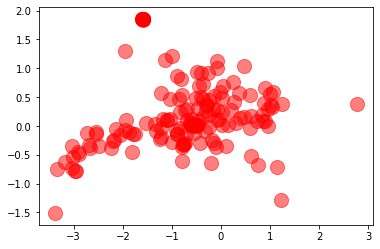

In [199]:
centers = kmeans.cluster_centers_
#print(kmeans.labels_)
labels, counts = np.unique(kmeans.labels_[kmeans.labels_>=0], return_counts=True)
print(np.c_[labels[np.argsort(-counts)[:]],counts[np.argsort(-counts)[:]]])
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
print(len(filenames))
print(len(kmeans.labels_))

In [213]:
fset=set(np.asarray(filenames)[np.where(kmeans.labels_==17)[0].tolist()])
#[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
[open(f).readlines() for f in fset]

[['IyEvdXNyL2Jpbi9wZXJsCiMgRGViaWFuIHJlcXVpcmVkIHNoZWJhbmcgYWJvdmUKIyBPcmlnaW5h\n',
  'bCBzaGViYW5nIGJlbG93CiMgIyEvdXNyL2Jpbi9lbnYgcGVybAojICRJZDogdGxtZ3IucGwgNDk4\n',
  'ODUgMjAxOS0wMS0zMSAxOToyNzowMFoga2FybCAkCiMKIyBDb3B5cmlnaHQgMjAwOC0yMDE5IE5v\n',
  'cmJlcnQgUHJlaW5pbmcKIyBUaGlzIGZpbGUgaXMgbGljZW5zZWQgdW5kZXIgdGhlIEdOVSBHZW5l\n',
  'cmFsIFB1YmxpYyBMaWNlbnNlIHZlcnNpb24gMgojIG9yIGFueSBsYXRlciB2ZXJzaW9uLgoKbXkg\n',
  'JHN2bnJldiA9ICckUmV2aXNpb246IDQ5ODg1ICQnOwpteSAkZGF0cmV2ID0gJyREYXRlOiAyMDE5\n',
  'LTAxLTMxIDIwOjI3OjAwICswMTAwIChUaHUsIDMxIEphbiAyMDE5KSAkJzsKbXkgJHRsbWdycmV2\n',
  'aXNpb247Cm15ICR0bG1ncnZlcnNpb247Cm15ICRwcmc7Cm15ICRiaW5kaXI7CmlmICgkc3ZucmV2\n',
  'ID1+IG0vOiAoWzAtOV0rKSAvKSB7CiAgJHRsbWdycmV2aXNpb24gPSAkMTsKfSBlbHNlIHsKICAk\n',
  'dGxtZ3JyZXZpc2lvbiA9ICJ1bmtub3duIjsKfQokZGF0cmV2ID1+IHMvXi4qRGF0ZTogLy87CiRk\n',
  'YXRyZXYgPX4gcy8gXCguKiQvLzsKJHRsbWdydmVyc2lvbiA9ICIkdGxtZ3JyZXZpc2lvbiAoJGRh\n',
  'dHJldikiOwoKb3VyICRNYXN0ZXI7Cm91ciAkaXNtYWluID0gMTsKb3VyICRsb2FkbWVkaWFzc

In [220]:
model.save("model_1_15_gensim")
#model = gensim.models.Word2Vec.load("model_1_15_gensim")

2019-09-15 04:29:06,101 : INFO : loading Word2Vec object from model_1_15_gensim
2019-09-15 04:29:15,855 : INFO : loading wv recursively from model_1_15_gensim.wv.* with mmap=None
2019-09-15 04:29:15,856 : INFO : loading vectors from model_1_15_gensim.wv.vectors.npy with mmap=None
2019-09-15 04:29:16,262 : INFO : setting ignored attribute vectors_norm to None
2019-09-15 04:29:16,263 : INFO : loading vocabulary recursively from model_1_15_gensim.vocabulary.* with mmap=None
2019-09-15 04:29:16,263 : INFO : loading trainables recursively from model_1_15_gensim.trainables.* with mmap=None
2019-09-15 04:29:16,264 : INFO : loading syn1neg from model_1_15_gensim.trainables.syn1neg.npy with mmap=None
2019-09-15 04:29:16,649 : INFO : setting ignored attribute cum_table to None
2019-09-15 04:29:16,649 : INFO : loaded model_1_15_gensim


In [217]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

179241

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 
